---

# CSCI 3202, Fall 2022
# Homework 7
# Due: Friday November 4, 2022 at 6:00 PM

<br> 

### Your name:

<br> 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from collections import deque
import heapq

## Problem 1

### Discrete Robot Path Planning

A robotics group at CU needs some help designing a path planning algorithm that can navigate around the engineering center. To get started they have designed two test environments for you to implement breadth-first, depth-first, and uniform-cost search.

- In the first environment, every movement to an adjacent cell has a cost of 1. The first environment will be represented by the `edge_weights_1` dictionary. 

- In the second enviornment, traveling to adjacent cells has a random int cost between 1 and 100. The second environment will be represented by the `edge_weights_2` dictionary. 

- Both setups have the same obstacles, free space, and goal. The code below creates and gives a visual representation of the robot's environment. 

- The first figure shows the environment itself with free spaces, barriers, robot start, and goal point. 

- The second image shows an example of what a path might look like as the robot moves through the environment.

### Color representation
yellow = obstacle

teal = free space

pink = goal

grey = robot start

red = part of the path

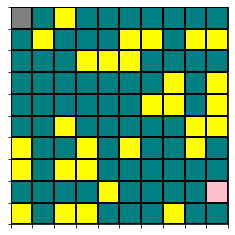

In [3]:
# Given code
def show_path(env, path):
    env_copy = np.copy(env)
    for cell in path:
        if(env_copy[cell[0]][cell[1]] >= 5 and env_copy[cell[0]][cell[1]] < 20):
            env_copy[cell[0]][cell[1]] = 41
    show_env(env_copy)
    
        
def show_env(env):
    cmap = colors.ListedColormap(['yellow', 'teal', 'pink', 'grey', 'red'])
    bounds = [0,5,20,30,40,41]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots()
    ax.imshow(env, cmap=cmap, norm=norm)
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xticks(np.arange(-.5, 10, 1));
    ax.set_yticks(np.arange(-.5, 10, 1));
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

    plt.show()
    
    


env = np.random.rand(10, 10) * 20
#set robot start position, grey color spot
start = (0, 0)
env[start[0]][start[1]] = 31

#set goal position pink square
goal = (8, 9)
env[goal[0]][goal[1]] = 21

# show the original graph
show_env(env)

# show an example path in the original graph, not a valid path
# example_path = [(1,1), (2,2), (3,3), (4,4), (5,4), (6,4), (7,4), (8,4), (8,5),(8,6),(8,7),(8,8)]
# show_path(env, example_path)

### Graph Representation
We represent the graph above as an adjacency dict in the following code. You can see what edges any cell has by indexing into the two dicts: 
- `edge_weights_1`
- `edge_weights_2`

For indexing, the top left of the graph is (row=0, col=0). Row values increase downward and column values increase to the right. 

So for example, if you wanted to look at the pink cell's (the goal location) connections you can call `print(edge_weights_2[(8,9)])` 

In [4]:
# create dictionary
edge_weights_1 = {}
edge_weights_2 = {}

for row, row_vals in enumerate(env):
    for col, val in enumerate(env[row]):
        # create dictionary
        edge_weights_1[(row, col)] = {}
        edge_weights_2[(row, col)] = {}
            
        #set all 6 direction options in edge_wights
        # 1) up
        if(row > 0):
            edge_weights_1[(row, col)][(row-1, col)] = 1
            edge_weights_2[(row, col)][(row-1, col)] = np.random.randint(101)
            if(col > 0):
                edge_weights_1[(row, col)][(row-1, col-1)] = 1
                edge_weights_2[(row, col)][(row-1, col-1)] = np.random.randint(101)
            if(col < 9):
                edge_weights_1[(row, col)][(row-1, col+1)] = 1
                edge_weights_2[(row, col)][(row-1, col+1)] = np.random.randint(101)
                
                
        #2) left
        if(col > 0):
            edge_weights_1[(row, col)][(row, col-1)] = 1
            edge_weights_2[(row, col)][(row, col-1)] = np.random.randint(101)
            if(row < 9):
                edge_weights_1[(row, col)][(row+1, col-1)] = 1
                edge_weights_2[(row, col)][(row+1, col-1)] = np.random.randint(101)
                
        #3) down 
        if(row < 9):
                edge_weights_1[(row, col)][(row+1, col)] = 1
                edge_weights_2[(row, col)][(row+1, col)] = np.random.randint(101)
                if(col < 9): 
                    edge_weights_1[(row, col)][(row+1, col+1)] = 1
                    edge_weights_2[(row, col)][(row+1, col+1)] = np.random.randint(101)
        
        #) right
        if(col < 9):
                edge_weights_1[(row, col)][(row, col+1)] = 1
                edge_weights_2[(row, col)][(row, col+1)] = np.random.randint(101)

for first_node in list(edge_weights_2.keys()):
    for second_node in list(edge_weights_2[first_node].keys()):
        
        # if first_node is yellow (an obstacle) the connection going both ways should be removed
        if(env[first_node[0]][[first_node[1]]] < 5):
            edge_weights_2[first_node].pop(second_node)
            edge_weights_2[second_node].pop(first_node)
            edge_weights_1[first_node].pop(second_node)
            edge_weights_1[second_node].pop(first_node)
        # if there is a connection, make sure both edges are the same
        else:
            w1 = edge_weights_2[first_node][second_node]
            w2 = edge_weights_2[second_node][first_node]
            if(w1 != w2):
                edge_weights_2[first_node][second_node] = edge_weights_2[second_node][first_node]
                
                
# These represent the same location
print('goal:   ', edge_weights_2[goal])
print('(8, 9): ', edge_weights_2[(8,9)])

goal:    {(7, 9): 14, (7, 8): 20, (8, 8): 14, (9, 8): 29, (9, 9): 69}
(8, 9):  {(7, 9): 14, (7, 8): 20, (8, 8): 14, (9, 8): 29, (9, 9): 69}


### Useful helper routines for searching


In [5]:
def path(previous, s): 
    '''
    `previous` is a dictionary chaining together the predecessor state that led to each state
    `s` will be None for the initial state
    otherwise, start from the last state `s` and recursively trace `previous` back to the initial state,
    constructing a list of states visited as we go
    '''
    if s is None:
        return []
    else:
        return path(previous, previous[s])+[s]

def pathcost(path, step_costs):
    '''
    add up the step costs along a path, which is assumed to be a list output from the `path` function above
    '''
    cost = 0
    for s in range(len(path)-1):
        cost += step_costs[path[s]][path[s+1]]
    return cost

In [6]:
def check_map(step_costs):
    ''' function to check if all the path costs are at least symmetric '''
    check_states = []
    for state1 in step_costs.keys():
        for state2 in step_costs[state1].keys():
            uh_oh = step_costs[state2][state1]!=step_costs[state1][state2]
            if uh_oh:
                print('Check the costs between states {} and {}'.format(state1,state2))
                check_states.append([state1,state2])
    if len(check_states)==0:
        print('all okay! (symmetric at least)')
    return check_states

---
### (1a)

#### Breadth-first search

Implement a function **breadth_first(start, goal, state_graph, return_cost)** to search the state space defined by the **state_graph** using breadth-first search:
* **start**: initial state (e.g., '(0,0)' or `start`)
* **end**: goal state (e.g., '(8,9)' or `goal`)
* **state_graph**: the dictionary defining the edge costs (e.g., `edge_weights_1` or `edge_weights_2`)
* **return_cost**: logical input representing whether or not to return the solution path cost
  * If **True**, then the output should be a tuple where the first value is the list representing the solution path as tuples (row, col) and the second value is the path cost
  * If **False**, then the only output is the solution path list object

Note that in the helper functions above, two useful routines for obtaining your solution path are provided (and can be used for all the search algorithms):
  * **path(previous, s)**: returns a list representing a path to state **s**, where **previous** is a dictionary that maps predecessors (values) to successors (keys)
  * **pathcost(path, step_costs)**: adds up the step costs defined by the **step_costs** graph (e.g., `edge_weights_2`) along the list of states **path**

In [7]:
# Solution:

def breadth_first(start, goal, state_graph, return_cost=False):
    ''' find a shortest sequence of states from start to the goal '''
    frontier = deque([start]) # doubly-ended queue of states
    previous = {start: None}  # start has no previous state; other states will
    if start == goal:
        path_out = [start]
        if return_cost: return path_out, pathcost(path_out, state_graph)
        return path_out
    while frontier:
        s = frontier.popleft()
        for s2 in state_graph[s]:
            if (s2 not in previous) and (s2 not in frontier):
                frontier.append(s2)
                previous[s2] = s
                if s2 == goal:
                    path_out = path(previous, s2)
                    if return_cost: return path_out, pathcost(path_out, state_graph)
                    return path_out

---
### (1b)

#### Uniform-cost search

First, let's create our own `Frontier_PQ` class to represent the frontier (priority queue) for uniform-cost search.  Note that the `heapq` package is imported in the helpers at the bottom of this notebook; you may find that package useful.  You could also use the `Queue` package.  Your implementation of the uniform-cost search frontier should adhere to these specifications:
* Instantiation arguments: 
  * **Frontier_PQ(start, cost)**
  * **start** is the initial state (e.g., **start**=(0,0) or `start`)
  * **cost** is the initial path cost (what should it be for the initial state?)
* Instantiation attributes/methods:
  * **states**: maintains a dictionary of states on the frontier, along with the _minimum_ path cost to arrive at them
  * **q**: a list of (cost, state) tuples, representing the elements on the frontier; should be treated as a priority queue (in contrast to the **states** dictionary, which is meant to keep track of the lowest-cost to each state)
  * appropriately initialize the starting state and cost
* Methods to implement:
  * **add(state, cost)**: add the (cost, state) tuple to the frontier
  * **pop()**: return the lowest-cost (cost, state) tuple, and pop it off the frontier
  * **replace(state, cost)**: if you find a lower-cost path to a state that's already on the frontier, it should be replaced using this method.
  
Note that there is some redundancy between the information stored in **states** and **q**. We only suggest to code it in this way because we think it's the most straightforward way to get something working. You could reduce the storage requirements by eliminating the redundancy, but it increases the time complexity because of the function calls needed to manipulate your priority queue to check for states (since that isn't how the frontier queue is ordered).

In [8]:
# Solution:

class Frontier_PQ:
    ''' frontier class for uniform search, ordered by path cost '''
    
    def __init__(self, start, cost):
        self.states = {}
        self.q = []
        self.add(start, cost)
        
    def add(self, state, cost):
        ''' push the new state and cost to get there onto the heap'''
        heapq.heappush(self.q, (cost, state))
        self.states[state] = cost

    def pop(self):
        (cost, state) = heapq.heappop(self.q)  # get cost of getting to explored state
        self.states.pop(state)    # and remove from frontier
        return (cost, state)

    def replace(self, state, cost):
        ''' found a cheaper route to `state`, replacing old cost with new `cost` '''
        self.states[state] = cost
        for i, (oldcost, oldstate) in enumerate(self.q):
            if oldstate==state and oldcost > cost:
                self.q[i] = (cost, state)
                heapq._siftdown(self.q, 0, i) # now i is posisbly out of order; restore
        return

Now, actually implement a function to search using `uniform_cost` search, called as **uniform_cost(start, goal, state_graph, return_cost)**:
* **start**: initial state
* **goal**: goal state
* **state_graph**: graph representing the connectivity and step costs of the state space (e.g., **edge_weights_1** or **edge_weights_2**)
* **return_cost**: logical input representing whether or not to return the solution path cost
  * If **True**, then the output should be a tuple where the first value is the list representing the solution path and the second value is the path cost
  * If **False**, then the only output is the solution path list object

In [9]:
# Solution:

def uniform_cost(start, goal, state_graph, return_cost=False):
    frontier = Frontier_PQ(start, 0)
    previous = {start : None}
    explored = {}
    while frontier:
        s= frontier.pop()
        if s[1] == goal:
            if return_cost: return path(previous, s[1]), s[0]
            return path(previous, s[1])
        explored[s[1]] = s[0]
        for s2 in state_graph[s[1]]:
            newcost = explored[s[1]]+state_graph[s[1]][s2]
            if (s2 not in explored) and (s2 not in frontier.states):
                frontier.add(s2, newcost)
                previous[s2] = s[1]
            elif (s2 in frontier.states) and (frontier.states[s2] > newcost):
                frontier.replace(s2, newcost)
                previous[s2] = s[1]

---

### (1c)

In the code cell below, for each of the two search algorithms defined above (in **1a** and **1b**), display the following information to the screen:

First, use `edge_weights_1`:
1) Print the path from start to goal 
2) Print the total cost of that path
3) Use the `show_path(env, path)` function to showcase the output your search algorithm. 

Second, use `edge_weights_2`:
1) Print the path from start to goal 
2) Print the total cost of that path
3) Use the `show_path(env, path)` function to showcase the output your search algorithm. 


Then, in a markdown cell below your code cell, write a few sentences:
* Which algorithm yields the shortest path for both edge weights?
* Does this surprise you? Or is this your expected result?

---------------------------------
uniform cost solution:  ([(0, 0), (0, 1), (1, 2), (2, 2), (3, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9)], 10)
---------------------------------
breadth_first solution: ([(0, 0), (1, 0), (2, 1), (3, 2), (4, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9)], 10)
---------------------------------


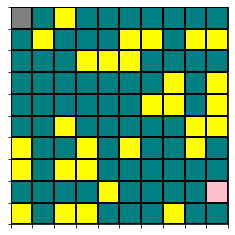

bfs_1


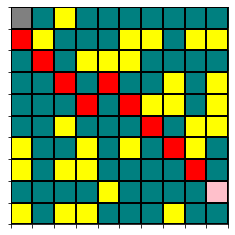

ucs_1


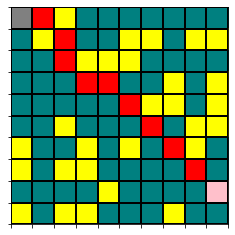

In [10]:
# Solution:
# First we show the solution paths for edge_wights_1
start = (0,0)
goal = (8,9)
graph = edge_weights_1
uniform_ret_1 = uniform_cost(start, goal, graph, True)
breadth_ret_1 = breadth_first(start, goal, graph, True)

print("---------------------------------")
print("uniform cost solution: ",uniform_cost(start, goal, graph, True))
print("---------------------------------")
print("breadth_first solution:", breadth_first(start, goal, graph, True))
print("---------------------------------")

show_env(env)
print('bfs_1')
show_path(env, breadth_ret_1[0])
print('ucs_1')
show_path(env, uniform_ret_1[0])



---------------------------------
uniform cost solution:  ([(0, 0), (0, 1), (1, 2), (2, 1), (2, 2), (3, 2), (4, 3), (5, 4), (6, 4), (7, 4), (8, 5), (7, 6), (6, 6), (7, 7), (8, 8), (8, 9)], 349)
---------------------------------
breadth_first solution: ([(0, 0), (1, 0), (2, 1), (3, 2), (4, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9)], 517)
---------------------------------


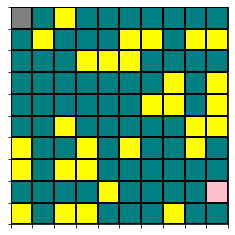

bfs_2


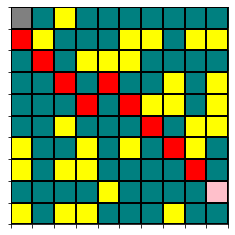

ucs_2


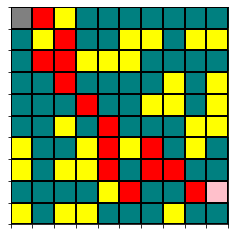

In [11]:
# Solution:
# Next we show the solution paths for edge_weights_2
start = (0,0)
goal = (8,9)
graph = edge_weights_2
uniform_ret_2 = uniform_cost(start, goal, graph, True)
breadth_ret_2 = breadth_first(start, goal, graph, True)

print("---------------------------------")
print("uniform cost solution: ", uniform_ret_2)
print("---------------------------------")
print("breadth_first solution:", breadth_first(start, goal, graph, True))
print("---------------------------------")



show_env(env)
print('bfs_2')
show_path(env, breadth_ret_2[0])
print('ucs_2')
show_path(env, uniform_ret_2[0])


## Problem 2: A*
Use the graph below to go through the A* algorithm by hand to determine the path that should be taken from $S$ to $G$. Heuristic values are shown in red above each node. Step costs between nodes are shown near each respective edge in black.

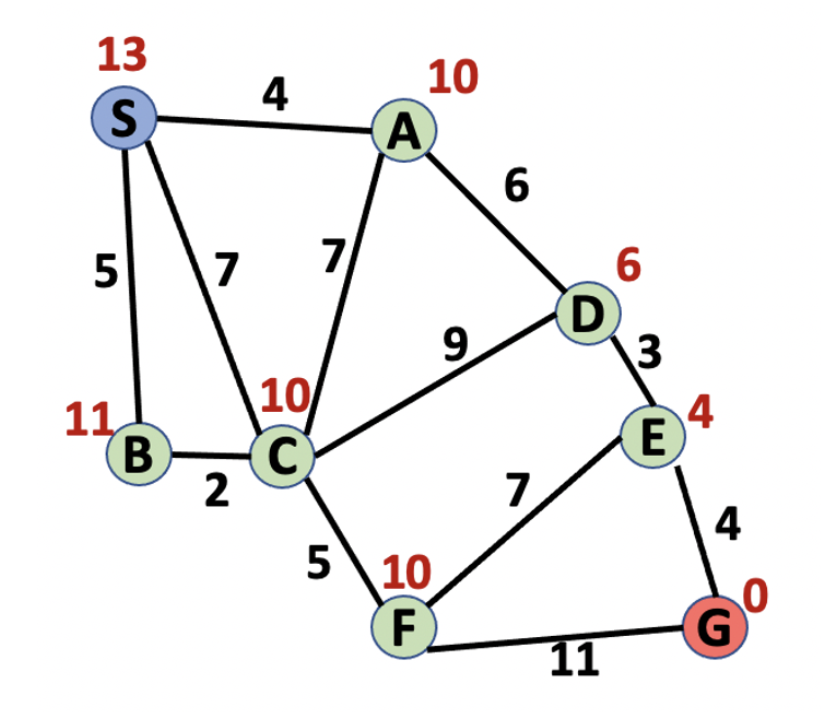

Fill in the table below to show the updated explored set and frontier with each iteration. The first iteration is done for you so that you can see the notation that is expected. If there are any ties, break them in alphabetical order.

| Explored Nodes | Frontier Nodes/Paths & f values  |
| :- | -: |
| $ $ | $(S,13)$ |
| $S$ | $(A,14),(B,16), (C,17)$ |
| $ $ | $(S,13)$ |
| $S$ | $(A,14),(B,16), (C,17)$ |
| $S,A$ | $(B,16), (D,16), (C,17)$ |
| $S,A,B$ | $ (D,16), (C,17)$ |
| $S,A,B,D$ | $ (C,17), (E,17) $ |
| $S,A,B,D,C$ | $ (E,17), (F,22) $ |
| $S,A,B,D,C,E$ | $ (G,17), (F,22) $ |
| $S,A,B,D,C,E,G$ | $ (F,22) $ |
| | |

### 2(a) - robot path planning

Using the robot environment in Problem 1, implement the A* algorithm using a Euclidean distance heuristic. In this implementation $h(n) = \sqrt{(x_g - x_n)^2 + (y_g - y_n)^2}$. In this equation; $x_g$ and $x_n$ represent the column location of goal and current node, repectively. The variables $y_g$ and $y_n$ are the row values of each node.

Run your code and display the results visually using the `show_path` method.



In [31]:
#A* code goes here

# heuristic function
def euclidean_distance(pos, goal):
    return np.sqrt((goal[0] - pos[0])**2 + (goal[1] - pos[1])**2)
    
    
def a_star(start, goal, state_graph, return_cost=False):
    
    frontier = Frontier_PQ(start, euclidean_distance(start, goal))
    previous = {start : None}
    explored = {}
    
    while frontier:
        s= frontier.pop()
        
        if s[1] == goal:
            if return_cost: return path(previous, s[1]), s[0]
            return path(previous, s[1])
        
        # subtract heuristic from cost to store only true cost
        true_cost = s[0] - euclidean_distance(s[1], goal)
        explored[s[1]] = true_cost
        
        for s2 in state_graph[s[1]]:
            newcost = explored[s[1]]+state_graph[s[1]][s2]
            # add heuristic value [h(n)] to true cost [g(n)] to get A* cost of f(n) = g(n) + h(n)
            a_star_cost = newcost + euclidean_distance(s2, goal)
            
            if (s2 not in explored) and (s2 not in frontier.states):
                frontier.add(s2, a_star_cost)
                previous[s2] = s[1]
            elif (s2 in frontier.states) and (frontier.states[s2] > a_star_cost):
                frontier.replace(s2, a_star_cost)
                previous[s2] = s[1]

---------------------------------
A* solution edge_weights_1:  ([(0, 0), (0, 1), (1, 2), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (8, 9)], 10.0)
---------------------------------
A* solution edge_weights_2: ([(0, 0), (0, 1), (1, 2), (2, 1), (2, 2), (3, 2), (4, 3), (5, 4), (6, 4), (7, 4), (8, 5), (7, 6), (6, 6), (7, 7), (8, 8), (8, 9)], 349.0)
---------------------------------


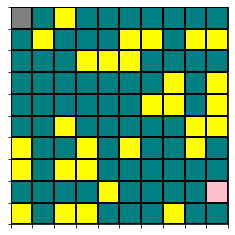

A* edge_weights_1


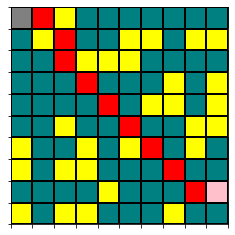

A* edge_weights_2


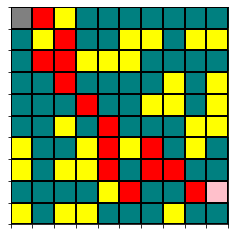

In [32]:
# Next we show the solution paths for edge_weights_2
start = (0,0)
goal = (8,9)
graph_1 = edge_weights_1
graph_2 = edge_weights_2
a_star_ret_1 = a_star(start, goal, graph_1, True)
a_star_ret_2 = a_star(start, goal, graph_2, True)

print("---------------------------------")
print("A* solution edge_weights_1: ", a_star_ret_1)
print("---------------------------------")
print("A* solution edge_weights_2:", a_star_ret_2)
print("---------------------------------")



show_env(env)
print('A* edge_weights_1')
show_path(env, a_star_ret_1[0])
print('A* edge_weights_2')
show_path(env, a_star_ret_2[0])

### 2(b)
Explain what benefits this algorithm has over bfs, dfs, and ucs, generally speaking, and how the results compare to your results for bfs and ucs implemented in Question 1.

A* is optimal, complete, and optimally efficient. That is, A* will find an optimal solution (optimal), is guaranteed to find the solution if it exists (complete), and no other algorithm is guaranteed to expand fewer nodes than A* (optimally efficient). This puts A* at an advantage over bfs and dfs, which while both are complete, neither are optimal nor guaranteed better efficiency than A*. UCS can guarantee optimality in graphs with positive edge weights, but A* is still more efficient, as it will never expand more nodes than UCS with an admissible heuristic. We can see above that A* performed better than BFS (cost of 517.0 vs 349.0) and as well as UCS (349.0 vs 349.0) when run on edge_weights_2, which is consistent with what has been discussed above.

## Problem 3 - Heuristics

For questions 3A, 3B, and 3C answer True or False and provide a brief explanation, or a counterexample where applicable.

### Part 3A. 
Depth-first search always expands at least as many nodes as A* search with an admissible heuristic.

False - DFS is not optimal, so there is a chance that it could go to straight the solution if it gets lucky.


### Part 3B. 
Uniform cost search always expands at least as many nodes as A* search with an admissible heuristic.

True - because uniform cost search is an optimal algorithm


### Part 3C. 
In the game of chess, in a single move, a rook can move any number of squares on a chessboard in a straight line, either vertically or horizontally, but cannot jump over other pieces. Manhattan distance is an admissible heuristic for the smallest number of moves required to move the rook from square A to square B.

False - manhattan distance will count the number of squares but the rook can move as many spaces as necessary in 1 move, so the heuristic will overestimate the true cost



---
## Problem 4 - Bayes nets - Prior Sampling

Bayes Nets implicitly encode joint probability distributions by chaining together local interactions to estimate global, indirect interactions. While we can use the network to directly calculate the conditional probability of some variable of interest, there are occasions where we would prefer to use **sampling**. 

In [15]:
%%html
<style>
table {float:left}
</style>

### (4a)

In your own words, describe sampling and why it can be useful when working with Bayes nets.

Sampling is the process of approximating probability distributions by generating a large number of random samples of data. Sampling allows us to assign random values to known probability distributions within a Bayes net and propogate the information through our network to estimate a probability of interest. This is particularly useful when working with very large Bayes nets, which can be computationally expensive to run, as many layers of probabilities must be calculated and processed throughout the network. Sampling allows a more direct approximation which sidesteps the problem of large numbers of probability calculations. 

### (4b)

A very important survey was given out to several hundred people walking along Pearl Street asking what their childhood pet was. Below is the resulting probability distribution of that survey.

| Pet     | P(Pet) |
|---------|--------|
| Cat     | 0.28   |
| Dog     | 0.37   |
| Pig     | 0.11   |
| Fish    | 0.18   |
| Rock    | 0.06   |


A list of random numbers were generated to sample from this probability distribution: 

[0.11, 0.97, 0.45, 0.16, 0.37, 0.76, 0.55, 0.42, 0.99, 0.84, 0.02, 0.29, 0.63, 0.69, 0.18]

Using these values:
- Map each value to a Pet based on the table above. 
- Calculate the sample distribution based on these values. 
- Reverse the order of the table (Rock, Fish, Pig, Dog, Cat) and recalculate the sample distribution. 

* [0.11, 0.97, 0.45, 0.16, 0.37, 0.76, 0.55, 0.42, 0.99, 0.84, 0.02, 0.29, 0.63, 0.69, 0.18] --> [Cat, Rock, Dog, Cat, Dog, Fish, Dog, Dog, Rock, Fish, Cat, Dog, Dog, Pig, Cat]
* 

| Pet     | P(Pet) |
|---------|--------|
| Cat     | 0.266   |
| Dog     | 0.400   |
| Pig     | 0.066   |
| Fish    | 0.133   |
| Rock    | 0.133   |

* [0.11, 0.97, 0.45, 0.16, 0.37, 0.76, 0.55, 0.42, 0.99, 0.84, 0.02, 0.29, 0.63, 0.69, 0.18] --> [Fish, Cat, Dog, Fish, Dog, Cat, Dog, Dog, Cat, Cat, Rock, Pig, Dog, Dog, Fish]
* 

| Pet     | P(Pet) |
|---------|--------|
| Cat     | 0.266   |
| Dog     | 0.400   |
| Pig     | 0.066   |
| Fish    | 0.200   |
| Rock    | 0.066   |

---

### (4c):  Bayesian network to model heart disease

You should recognize the following Bayesian network from your last homework. Recall that this figure uses Y and N to represent Yes and No, which can be represented as True and False Boolean values. 

Write a Python script that implements prior Sampling (the method used in class) to calculate the following:
- $P(HBP)$
- $P(HD)$
- $P(HD \mid Ath=T)$

Your script should generate 1000 samples for each question, where one sample includes all variable information that you need. For example, to calculate P(HD), you will need values for HBP, Ath, and Family History. Those three values constitute one sample. 

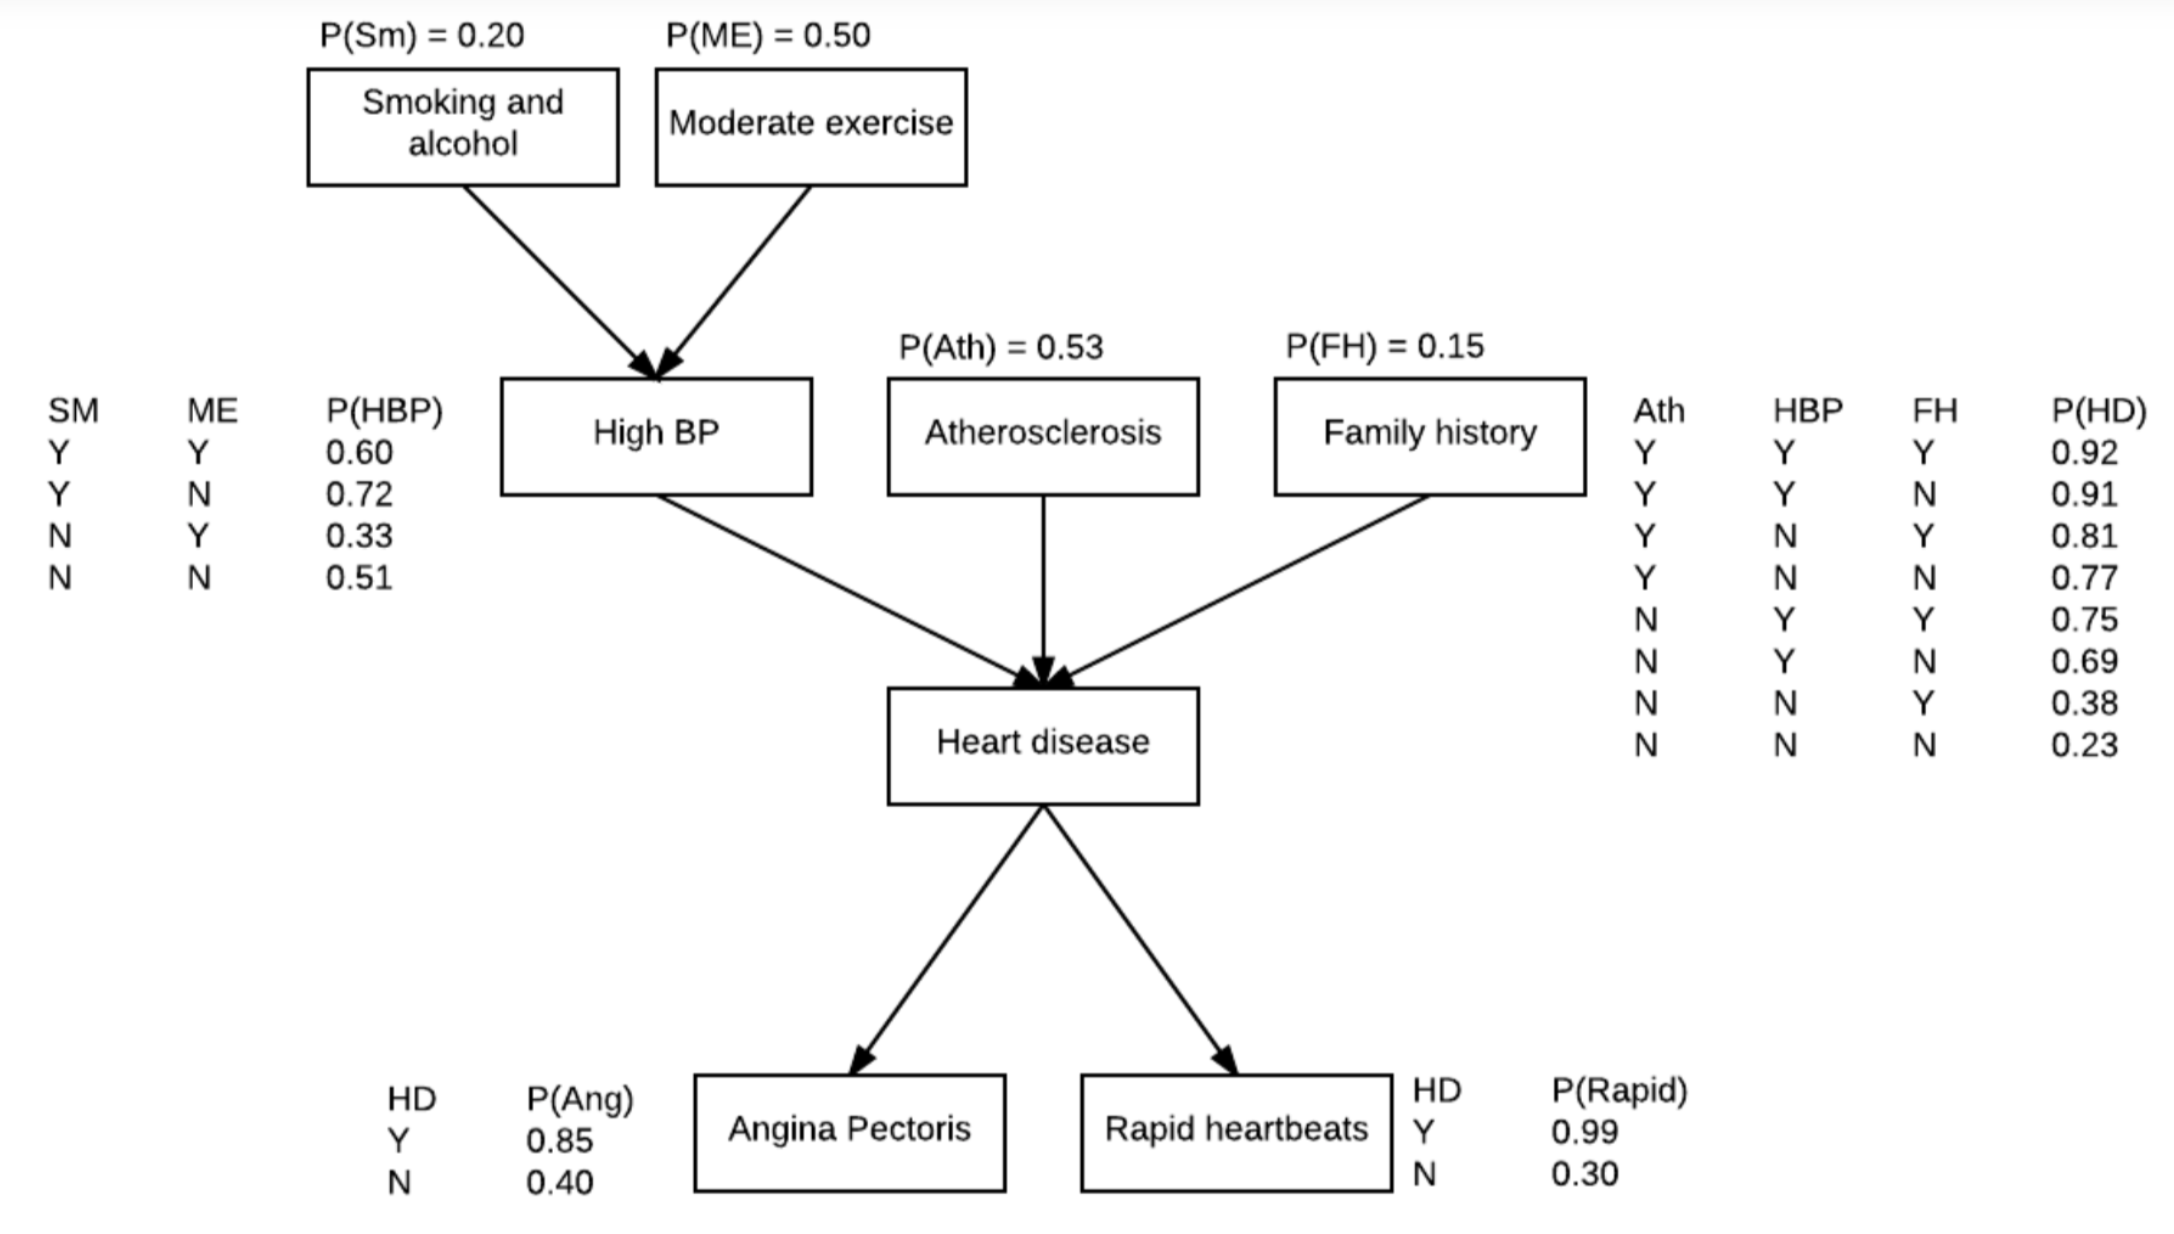

In [46]:
# HBP

n_samples = 1000
# draw random nums
sm_draws = np.random.random(n_samples)
me_draws = np.random.random(n_samples)
hbp_draws = np.random.random(n_samples)

# assign truthiness
sm_samples = [x < 0.2 for x in sm_draws]
me_samples = [x < 0.5 for x in me_draws]
hbp_samples = []

for i in range(n_samples):
    if sm_samples[i] and me_samples[i]: # TT
        hbp_samples.append(hbp_draws[i] < 0.6)
    if sm_samples[i] and not me_samples[i]: # TF
        hbp_samples.append(hbp_draws[i] < 0.72)
    if not sm_samples[i] and me_samples[i]: # FT
        hbp_samples.append(hbp_draws[i] < 0.33)
    if not sm_samples[i] and not me_samples[i]: # FF
        hbp_samples.append(hbp_draws[i] < 0.51)

# Calculate sample distribution
sum(hbp_samples) / len(hbp_samples)

0.47

In [67]:
# HD

n_samples = 1000
# draw random nums
sm_draws = np.random.random(n_samples)
me_draws = np.random.random(n_samples)
hbp_draws = np.random.random(n_samples)
ath_draws = np.random.random(n_samples)
fh_draws = np.random.random(n_samples)
hd_draws = np.random.random(n_samples)

# assign truthiness
sm_samples = [x < 0.2 for x in sm_draws]
me_samples = [x < 0.5 for x in me_draws]
hbp_samples = []
ath_samples = [x < 0.53 for x in ath_draws]
fh_samples = [x < 0.15 for x in fh_draws]
hd_samples = []

for i in range(n_samples):
    if sm_samples[i] and me_samples[i]: # TT
        hbp_samples.append(hbp_draws[i] < 0.6)
    if sm_samples[i] and not me_samples[i]: # TF
        hbp_samples.append(hbp_draws[i] < 0.72)
    if not sm_samples[i] and me_samples[i]: # FT
        hbp_samples.append(hbp_draws[i] < 0.33)
    if not sm_samples[i] and not me_samples[i]: # FF
        hbp_samples.append(hbp_draws[i] < 0.51)

        
for i in range(n_samples):
    if ath_samples[i] and hbp_samples[i] and fh_samples[i]: # TTT
        hd_samples.append(hd_draws[i] < 0.92)
    if ath_samples[i] and hbp_samples[i] and fh_samples[i]: # TTF
        hd_samples.append(hd_draws[i] < 0.91)
    if ath_samples[i] and hbp_samples[i] and fh_samples[i]: # TFT
        hd_samples.append(hd_draws[i] < 0.81)
    if ath_samples[i] and hbp_samples[i] and fh_samples[i]: # TFF
        hd_samples.append(hd_draws[i] < 0.77)
    if ath_samples[i] and hbp_samples[i] and fh_samples[i]: # FTT
        hd_samples.append(hd_draws[i] < 0.75)
    if ath_samples[i] and hbp_samples[i] and fh_samples[i]: # FTF
        hd_samples.append(hd_draws[i] < 0.69)
    if ath_samples[i] and hbp_samples[i] and fh_samples[i]: # FFT
        hd_samples.append(hd_draws[i] < 0.38)    
    if ath_samples[i] and hbp_samples[i] and fh_samples[i]: # FFF
        hd_samples.append(hd_draws[i] < 0.23)
        
# Calculate sample distribution
sum(hd_samples) / len(hd_samples)

0.7916666666666666

In [63]:
# HD, Ath=True

n_samples = 1000
# draw random nums
sm_draws = np.random.random(n_samples)
me_draws = np.random.random(n_samples)
hbp_draws = np.random.random(n_samples)
ath_draws = np.random.random(n_samples)
fh_draws = np.random.random(n_samples)
hd_draws = np.random.random(n_samples)

# assign truthiness
sm_samples = [x < 0.2 for x in sm_draws]
me_samples = [x < 0.5 for x in me_draws]
hbp_samples = []
ath_samples = [True for x in ath_draws]
fh_samples = [x < 0.15 for x in fh_draws]
hd_samples = []

for i in range(n_samples):
    if sm_samples[i] and me_samples[i]: # TT
        hbp_samples.append(hbp_draws[i] < 0.6)
    if sm_samples[i] and not me_samples[i]: # TF
        hbp_samples.append(hbp_draws[i] < 0.72)
    if not sm_samples[i] and me_samples[i]: # FT
        hbp_samples.append(hbp_draws[i] < 0.33)
    if not sm_samples[i] and not me_samples[i]: # FF
        hbp_samples.append(hbp_draws[i] < 0.51)

        
for i in range(n_samples):
    if ath_samples[i] and hbp_samples[i] and fh_samples[i]: # TTT
        hd_samples.append(hd_draws[i] < 0.92)
    if ath_samples[i] and hbp_samples[i] and fh_samples[i]: # TTF
        hd_samples.append(hd_draws[i] < 0.91)
    if ath_samples[i] and hbp_samples[i] and fh_samples[i]: # TFT
        hd_samples.append(hd_draws[i] < 0.81)
    if ath_samples[i] and hbp_samples[i] and fh_samples[i]: # TFF
        hd_samples.append(hd_draws[i] < 0.77)
    if ath_samples[i] and hbp_samples[i] and fh_samples[i]: # FTT
        hd_samples.append(hd_draws[i] < 0.75)
    if ath_samples[i] and hbp_samples[i] and fh_samples[i]: # FTF
        hd_samples.append(hd_draws[i] < 0.69)
    if ath_samples[i] and hbp_samples[i] and fh_samples[i]: # FFT
        hd_samples.append(hd_draws[i] < 0.38)    
    if ath_samples[i] and hbp_samples[i] and fh_samples[i]: # FFF
        hd_samples.append(hd_draws[i] < 0.23)
        
# Calculate sample distribution
sum(hd_samples) / len(hd_samples)

0.7302631578947368